# Chapter 15 - Processing Sequence using RNN and CNN

- RNN are not only types of neural network capable of handling sequence data.
- RNN is like feedforward network except it has a connection backward
- Output from RNN for single instance
    $ y_{t} = \phi (W_{x}^{T} x_{t} + W_{y}^T y_{(t-1)} + b)$
- Many reachers prefer to use "tanh" activation function for RNN than ReLU function

## Memory Cell
- Output of each recurrent neuron at time step "t" is function of input from previous time step - you could say it is a memory.
- A part of neural network that preserves some state across time step is called Memory Cell.
- Single recurrent neuron is basic cell capable of learning only short patterns (about 10 steps long but varies depending on task)
- In general a cell state at anytime "t" is denoted as $h_{t}$ (hidden state)

## Input & Output Sequence
- RNN can take sequence of input and produce sequence of output
- Sequence to Sequence: network is useful in predicting timeseries such as stock market prices
- Sequence to Vector: You can also feed network with series of input with output for last one; e.g. movie rating based on comments
- Vector to Sequence: You can feed same input vector again and again and let output be the sequence; e.g. captioning an image
- Lastly we have sequence to vector network called encoders, followed by vector to sequence network called Decoders; used for translating one language to another. Encoder converts input in one language to vector and decoders convert vectorsto differnt language

## Training RNN on Time series

#### Since RNN takes longer than CNN or Dense networks - we will use Collab workbook for this

In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import os

Generate time series for given number of steps.

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise

    # Function will return array of shape (Batch Size, Time Steps, 1)
    return series[..., np.newaxis].astype(np.float32)

When dealing with timeseries (and other type of sequence like sentences), the input feature are generally represented in 3D array of shape (Batch size, time steps, dimensionality]. For univariate series dimentionality is usally 1. And more for multivariate series

In [3]:
np.random.seed(42)

n_steps = 50

# generate series of 10000 points for 50 steps
series = generate_time_series(10000, n_steps + 1)

# Create training, validation and test set
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

X_train contains 7000 timeseries while X_valid has 2000 and X_test as 1000. Since we want to forecast a single value from each set, the target column vectors are (7000, 1) for y_train.

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

In [5]:
X_train[:2]

array([[[ 0.4596948 ],
        [ 0.31486678],
        [ 0.12497123],
        [-0.1039134 ],
        [-0.33817387],
        [-0.53167135],
        [-0.65472883],
        [-0.6680997 ],
        [-0.6068115 ],
        [-0.50168324],
        [-0.27951923],
        [-0.15070675],
        [ 0.01001816],
        [ 0.11860766],
        [ 0.09566415],
        [ 0.1479297 ],
        [ 0.16850619],
        [ 0.19524719],
        [ 0.22094081],
        [ 0.38448656],
        [ 0.4021102 ],
        [ 0.5566975 ],
        [ 0.55000687],
        [ 0.47437248],
        [ 0.29733396],
        [ 0.13306592],
        [-0.1292547 ],
        [-0.36367297],
        [-0.49515054],
        [-0.65279794],
        [-0.6665792 ],
        [-0.5604573 ],
        [-0.50344354],
        [-0.28775147],
        [-0.12684062],
        [-0.0095053 ],
        [ 0.12024356],
        [ 0.18013756],
        [ 0.1559989 ],
        [ 0.1756968 ],
        [ 0.217454  ],
        [ 0.30272725],
        [ 0.38143268],
        [ 0

In [6]:
y_train[:2]

array([[-0.35489398],
       [ 0.11629631]], dtype=float32)

### Plot sets

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

#### Plot for X_train, and y_train

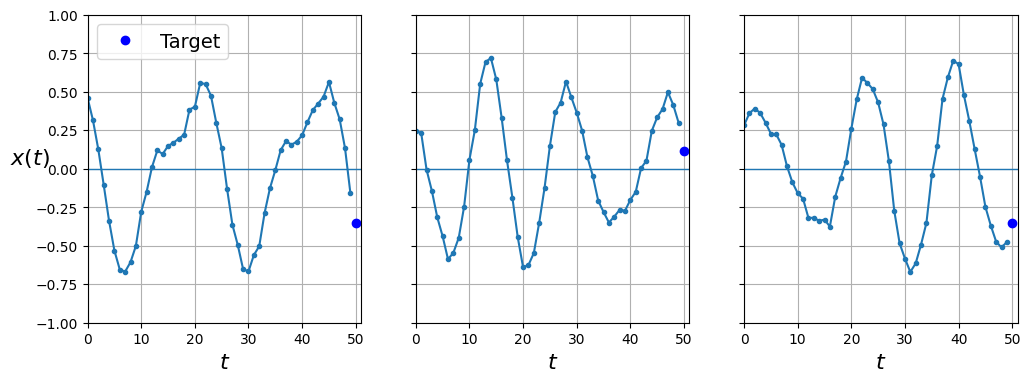

In [8]:
# Create 3 figures
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_train[col, :, 0], y_train[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
plt.show()

#### Plot for X_Valid

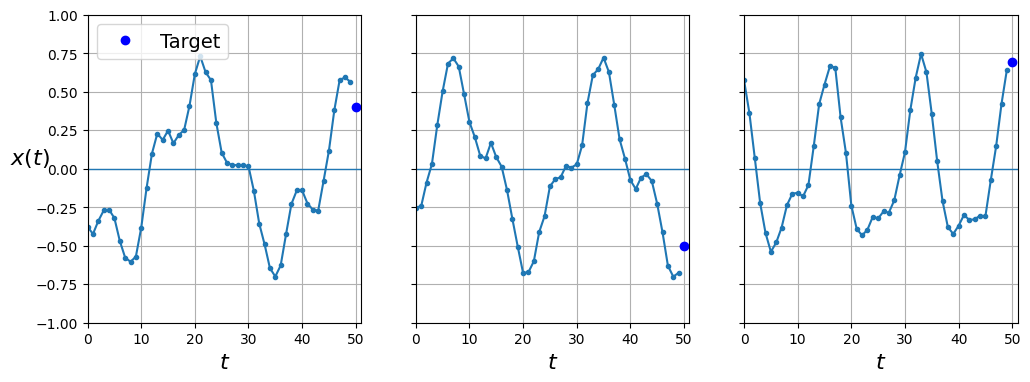

In [9]:
# Create 3 figures
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
plt.show()

#### Plot for X_Test

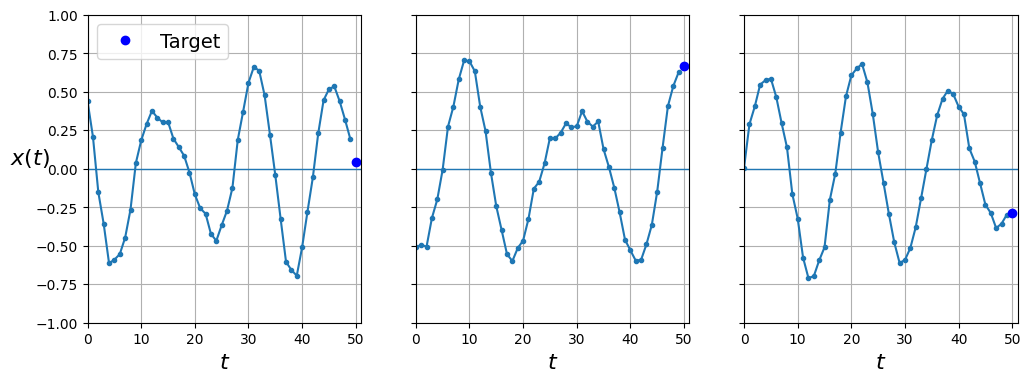

In [10]:
# Create 3 figures
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_test[col, :, 0], y_test[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
plt.show()

### Computing some baselines
To check the performance of our model, we make use of different options.
Option 1: Predict the last value in the series - this is naive forecasting.
Option 2: Use fully connected network (CNN) and perform simple linear regression, so that each prediction is the linear combination of values in the time series;

#### Naive Forecasting Method

In [11]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mse(y_valid, y_pred))

np.float32(0.020211367)

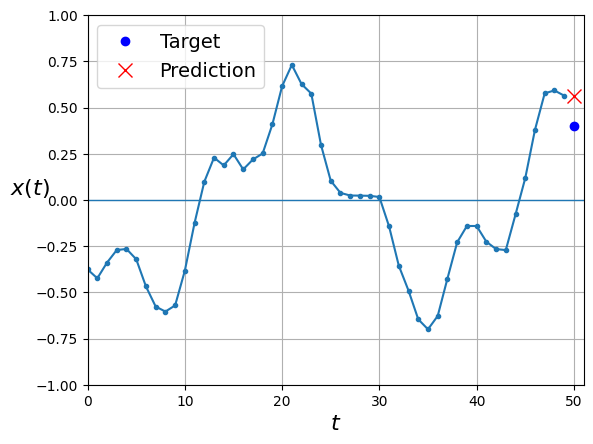

In [12]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Model's Mean squared error is 0.02

### Making prediction using linear regression

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1108 - val_loss: 0.0318
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0278 - val_loss: 0.0166
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0152 - val_loss: 0.0111
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0105 - val_loss: 0.0090
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0085 - val_loss: 0.0078
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0074 - val_loss: 0.0070
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [14]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036


0.0036819111555814743

The model's mean squared error is only 0.0037

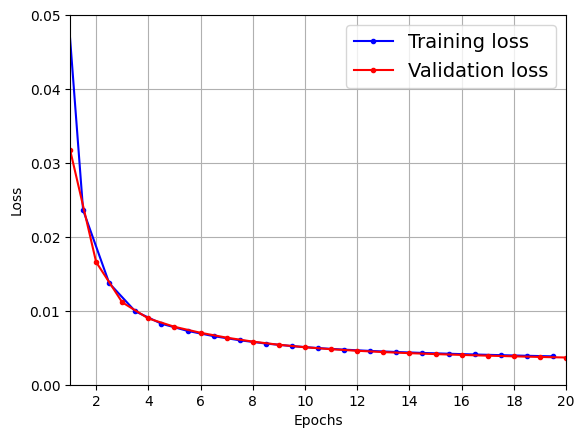

In [15]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


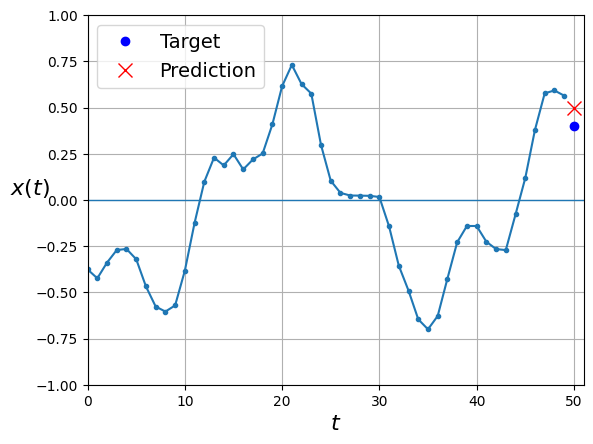

In [16]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using Simple RNN

In [17]:
# this is the simplest RNN - single layer with single neuron. No need to specify length of input sequence
# by default simple RNN uses tanh activation function
# by default recurrent layers in keras only return final output. To make them output at every timestep, set return_sequence=True
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)

In [19]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1711 - val_loss: 0.0452
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0393 - val_loss: 0.0286
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0264 - val_loss: 0.0213
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0204 - val_loss: 0.0174
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0169 - val_loss: 0.0149
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0148 - val_loss: 0.0133
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0134 - val_loss: 0.0123
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0125 - val_loss: 0.0116
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0119 - val_loss: 0.0112
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0116 - val_loss: 0.0110
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/ste

In [20]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110


0.010925402864813805

Simple RNN Model with one neuron has MSE of 0.01 which is poor than Linear Regression model.

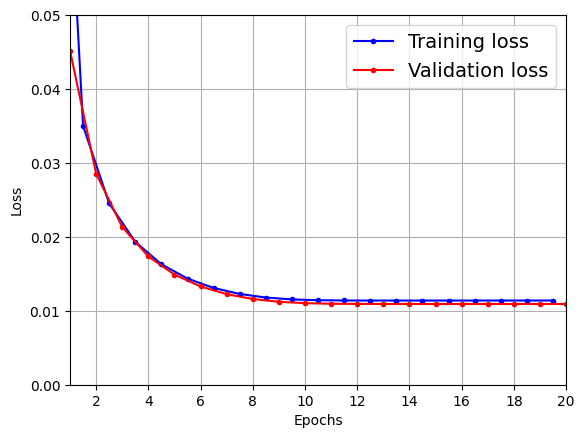

In [21]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


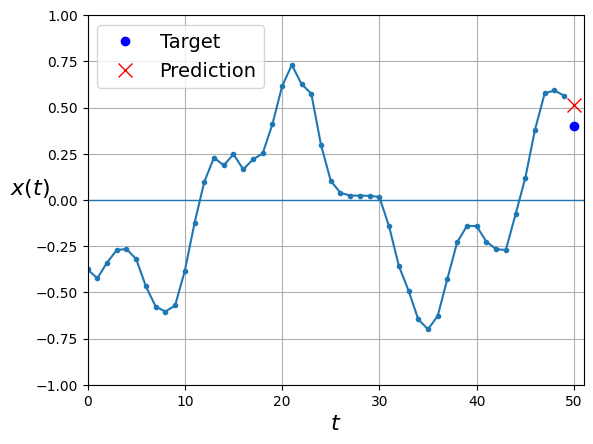

In [22]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

# Deep RNN

Stack up RNN to create Deep RNN. Ensure return_sequences is set to True for all layers except the last one to get 3D array containing output from all timesteps. <br>
If you don't put return_sequence=True for all layers, the Deep network will return result only from the last step which will be 2D array.

In [23]:
# Below will take ages to run
np.random.seed(42)
tf.random.set_seed(42)

# set return sequence=True for all layers to get output from all timesteps
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.1034 - val_loss: 0.0059
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0052 - val_loss: 0.0036
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━

In [24]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026


0.0027854950167238712

MSE is set to 0.0028 which is better than linear regression model

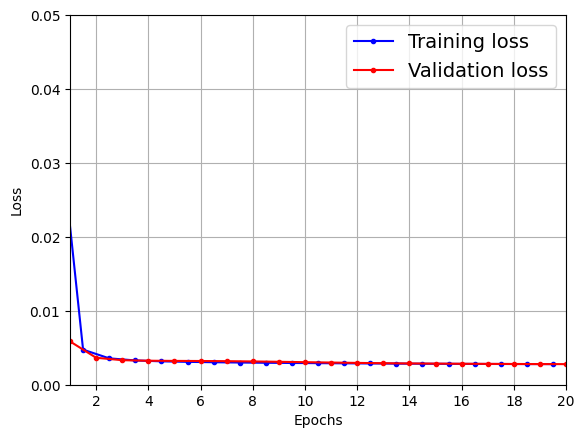

In [25]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


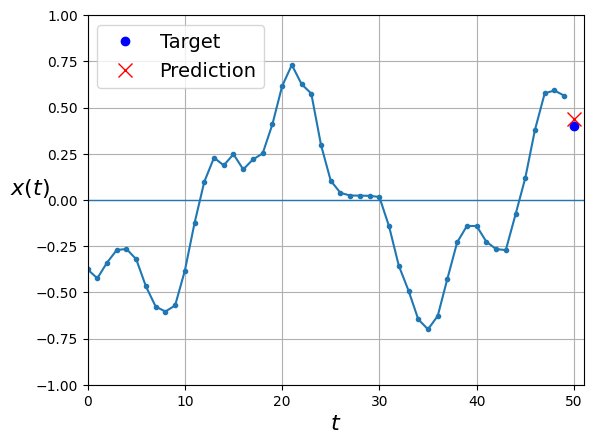

In [26]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Creating Deep Network with RNN returning only last output
For this set the return sequence=True for first layer and dont set for other layers
the last layer also is Dense in this case; as the RNN is presumably uses hidden state of other layers to carry over the information. Also RNN uses tanh activation, the values range between -1 and +1. Putting Dense layer makes the network perform little faster. Also you can choose the activation function of your choice.

In [27]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0969 - val_loss: 0.0066
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0059 - val_loss: 0.0045
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/

In [28]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026


0.00272457511164248

MSE is 0.0026 which is much better than other networks we have seen so far.

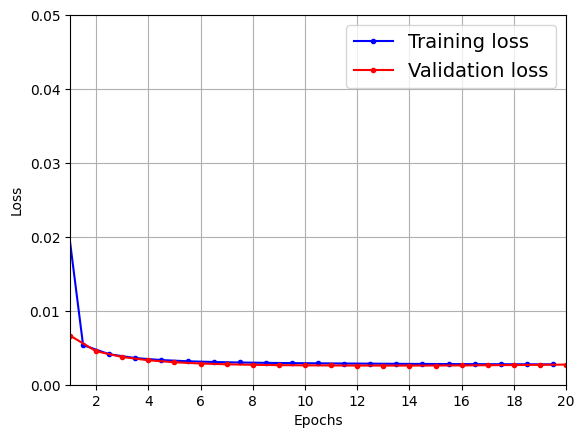

In [29]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


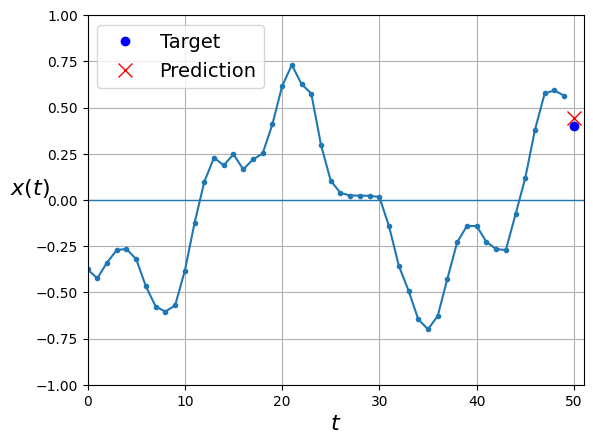

In [30]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

# Forecasting several time steps ahead
Predicting 10 values way before.

Option 1: Use the trained model to predict the next value and then add this predicted value to input and predict next and so on... <br>

In [31]:
np.random.seed(43)
series = generate_time_series(1, n_steps+10)

In [32]:
X_new, Y_new=series[:, :n_steps], series[:, n_steps:]
X=X_new

# Get step ahead and predict the value 10 times. Add predicted value to input again to make next prediction
for step_ahead in range(10):
  y_pred_one=model.predict(X[:, step_ahead:])[:, np.newaxis, :]
  X=np.concatenate([X, y_pred_one], axis=1)

Y_pred=X[:, n_steps:]
Y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


array([[[ 0.5659027 ],
        [ 0.54851836],
        [ 0.4760759 ],
        [ 0.3575264 ],
        [ 0.21201831],
        [ 0.06499957],
        [-0.05156274],
        [-0.11555451],
        [-0.14556132],
        [-0.15657873]]], dtype=float32)

In [33]:
Y_pred.shape

(1, 10, 1)

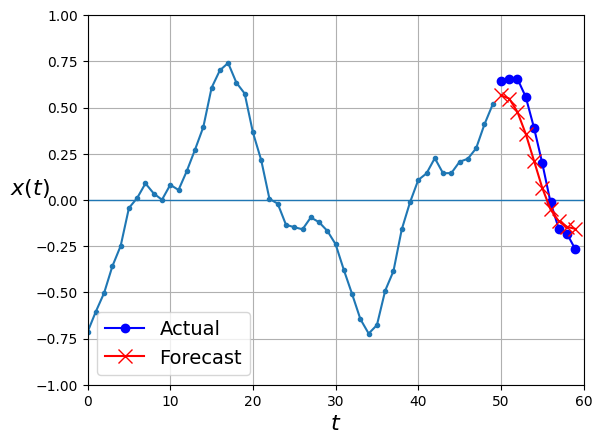

In [34]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [39]:
np.mean(keras.metrics.mse(Y_valid, Y_pred))

np.float32(0.255459)

In [40]:
Y_naive_pred = np.tile(X_valid[:, -1], 10) # take the last time step value, and repeat it 10 times
np.mean(keras.metrics.mse(Y_valid, Y_naive_pred))

np.float32(0.25697407)

Option 2: Train RNN to predict all 10 values at once. We can use Sequence to Vector model but instead of 1 it will predict 10 values. <br>
To do that before we need to create targets to vectors containing the next 10 values.

In [41]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]
X_sample, y_sample = series[:50, :n_steps], series[:50, -10:, 0]

In [42]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

In [43]:
X_sample[1]

array([[ 0.2655248 ],
       [ 0.23108748],
       [ 0.03770885],
       [-0.03080609],
       [-0.17988688],
       [-0.31881845],
       [-0.46522513],
       [-0.5637513 ],
       [-0.5580675 ],
       [-0.43465146],
       [-0.3046509 ],
       [-0.1521073 ],
       [ 0.12169014],
       [ 0.33661968],
       [ 0.54001147],
       [ 0.6530332 ],
       [ 0.7231088 ],
       [ 0.6870334 ],
       [ 0.4791239 ],
       [ 0.36695585],
       [ 0.06045676],
       [-0.18181656],
       [-0.3735148 ],
       [-0.5557579 ],
       [-0.622744  ],
       [-0.6718724 ],
       [-0.58777   ],
       [-0.46400538],
       [-0.21696734],
       [ 0.02887913],
       [ 0.19160746],
       [ 0.37201372],
       [ 0.45309448],
       [ 0.546951  ],
       [ 0.44949853],
       [ 0.43388122],
       [ 0.28403777],
       [ 0.11527138],
       [ 0.06192801],
       [-0.09399972],
       [-0.17760696],
       [-0.2306893 ],
       [-0.27720088],
       [-0.28476682],
       [-0.2779141 ],
       [-0

In [44]:
y_sample[1]

array([0.0051308 , 0.08580116, 0.20665818, 0.35378858, 0.3838966 ,
       0.4867545 , 0.4927417 , 0.43097195, 0.21307838, 0.13890865],
      dtype=float32)

In [45]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.1076 - val_loss: 0.0247
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0230 - val_loss: 0.0173
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0166 - val_loss: 0.0143
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0138 - val_loss: 0.0129
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0124 - val_loss: 0.0118
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0116 - val_loss: 0.0109
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0110 - val_loss: 0.0105
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0106 - val_loss: 0.0099
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0103 - val_loss: 0.0093
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0097 - val_loss: 0.0096
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0093 - val_loss: 0.0090
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/s

In [46]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


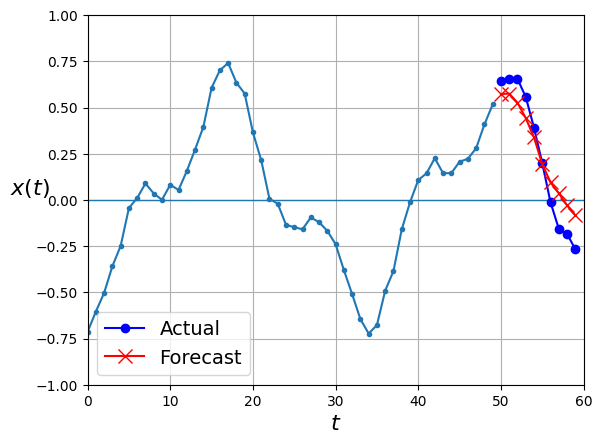

In [47]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

this model works well. the mse for next 10 steps is 0.008.

Option 3: We can even go further and predict 10 values using sequence to sequence model. <br>
The advantage of this approach is that the loss will contain a term for output of the RNN at each and every time step, not just output at the last step. This means there will be many more error gradient flowing through the mode. And they will not have flow through time; they will also flow from the output of each time step. This will both stablize and speed up the training process.

<br>
To be clear at timestep 0, the model will output vector containing forecast for timestep 1 to 10 <br>
at timestep 1, the model will output vector containing forecast for timestep 2 to 11. <br>
and so on

In [48]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)

# Split the train, val and test set
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]

# create target a sequence of 10D vectors
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [49]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

In [50]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mse(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - last_time_step_mse: 0.0611 - loss: 0.0702 - val_last_time_step_mse: 0.0224 - val_loss: 0.0358
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0225 - loss: 0.0355 - val_last_time_step_mse: 0.0172 - val_loss: 0.0311
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0179 - loss: 0.0307 - val_last_time_step_mse: 0.0141 - val_loss: 0.0274
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0157 - loss: 0.0282 - val_last_time_step_mse: 0.0145 - val_loss: 0.0269
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0143 - loss: 0.0266 - val_last_time_step_mse: 0.0147 - val_loss: 0.0260
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - last_time_step_mse: 0.0124 - loss: 0.0249 - val_last_time_step_mse: 0.0088 - val_loss: 0.0219
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0103 - loss: 0.0229 - val_last_ti

In [51]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_8 (SimpleRNN)        │ (None, None, 20)       │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, None, 20)       │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 10)       │           210 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,412 (17.24 KB)

 Trainable params: 1,470 (5.74 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,942 (11.50 KB)

In [52]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


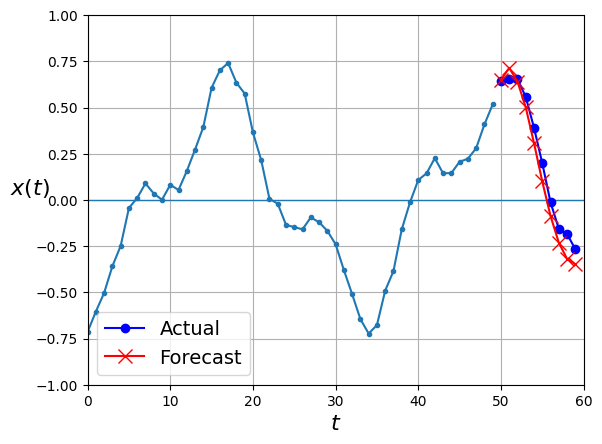

In [53]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# Handling Long Sequences

## Unstable Gradient Problem

### Batch Normalization Technique
To tackle this there are many options available. However, Relu cannot be used with Deep RNN. <br>
Below is using Batch Normalization Technique

In [54]:
np.random.seed(42)
tf.random.set_seed(42)

# add batch normalization layer between the layers. BN is not possible between timesteps
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - last_time_step_mse: 0.3115 - loss: 0.3365 - val_last_time_step_mse: 0.0675 - val_loss: 0.0766
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - last_time_step_mse: 0.0411 - loss: 0.0524 - val_last_time_step_mse: 0.0367 - val_loss: 0.0479
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0330 - loss: 0.0444 - val_last_time_step_mse: 0.0292 - val_loss: 0.0424
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0274 - loss: 0.0398 - val_last_time_step_mse: 0.0242 - val_loss: 0.0386
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - last_time_step_mse: 0.0236 - loss: 0.0366 - val_last_time_step_mse: 0.0214 - val_loss: 0.0359
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - last_time_step_mse: 0.0214 - loss: 0.0346 - val_last_time_step_mse: 0.0197 - val_loss: 0.0340
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0199 - loss: 0.0331 - val_last_

### Deep RNN with Layer Normalization

In [55]:
from tensorflow.keras.layers import LayerNormalization

In [56]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,
                                                             activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [57]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [58]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - last_time_step_mse: 0.1960 - loss: 0.2021 - val_last_time_step_mse: 0.0495 - val_loss: 0.0602
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - last_time_step_mse: 0.0468 - loss: 0.0572 - val_last_time_step_mse: 0.0370 - val_loss: 0.0495
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - last_time_step_mse: 0.0350 - loss: 0.0478 - val_last_time_step_mse: 0.0272 - val_loss: 0.0419
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - last_time_step_mse: 0.0271 - loss: 0.0417 - val_last_time_step_mse: 0.0229 - val_loss: 0.0376
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.0236 - loss: 0.0380 - val_last_time_step_mse: 0.0203 - val_loss: 0.0351
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - last_time_step_mse: 0.0213 - loss: 0.0354 - val_last_time_step_mse: 0.0189 - val_loss: 0.0344
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - last_time_step_mse: 0.0196 - loss: 0.0340 - val_la

# LSTM
To have some memory when dealing with long sequence

In [59]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - last_time_step_mse: 0.0916 - loss: 0.1017 - val_last_time_step_mse: 0.0338 - val_loss: 0.0535
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - last_time_step_mse: 0.0296 - loss: 0.0496 - val_last_time_step_mse: 0.0199 - val_loss: 0.0416
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.0189 - loss: 0.0399 - val_last_time_step_mse: 0.0156 - val_loss: 0.0364
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - last_time_step_mse: 0.0151 - loss: 0.0351 - val_last_time_step_mse: 0.0134 - val_loss: 0.0329
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.0132 - loss: 0.0322 - val_last_time_step_mse: 0.0121 - val_loss: 0.0306
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - last_time_step_mse: 0.0118 - loss: 0.0301 - val_last_time_step_mse: 0.0121 - val_loss: 0.0293
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - last_time_step_mse: 0.0109 - loss: 0.0287 - val_las

In [60]:
model.evaluate(X_valid, Y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - last_time_step_mse: 0.0092 - loss: 0.0237


[0.023717811331152916, 0.009005650877952576]

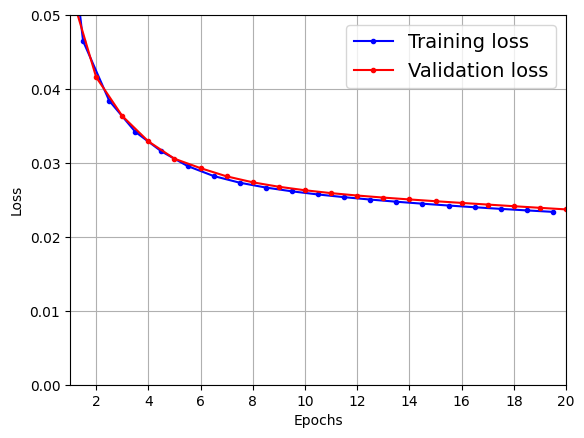

In [61]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [62]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step


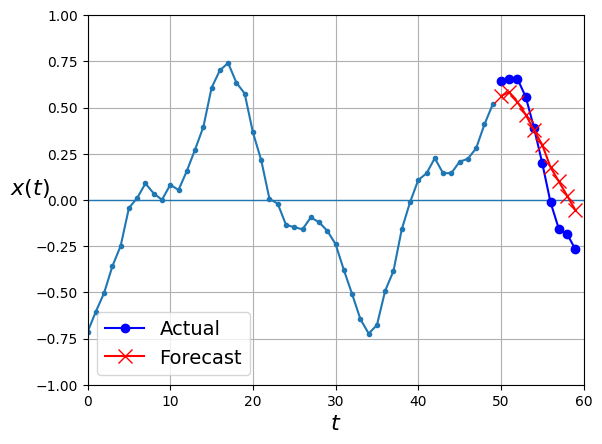

In [63]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# GRU

In [64]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - last_time_step_mse: 0.0906 - loss: 0.0969 - val_last_time_step_mse: 0.0406 - val_loss: 0.0520
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.0394 - loss: 0.0495 - val_last_time_step_mse: 0.0323 - val_loss: 0.0444
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - last_time_step_mse: 0.0325 - loss: 0.0433 - val_last_time_step_mse: 0.0271 - val_loss: 0.0395
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.0275 - loss: 0.0388 - val_last_time_step_mse: 0.0234 - val_loss: 0.0353
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.0228 - loss: 0.0346 - val_last_time_step_mse: 0.0179 - val_loss: 0.0319
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.0172 - loss: 0.0306 - val_last_time_step_mse: 0.0145 - val_loss: 0.0291
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - last_time_step_mse: 0.0142 - loss: 0.0285 - val_las

In [65]:
model.evaluate(X_valid, Y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - last_time_step_mse: 0.0097 - loss: 0.0233


[0.02339489571750164, 0.009691017679870129]

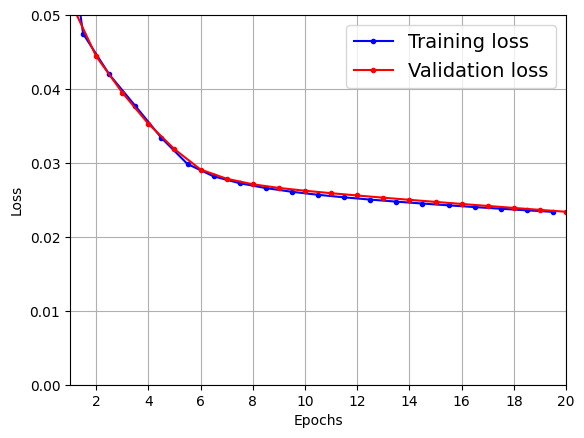

In [66]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [67]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


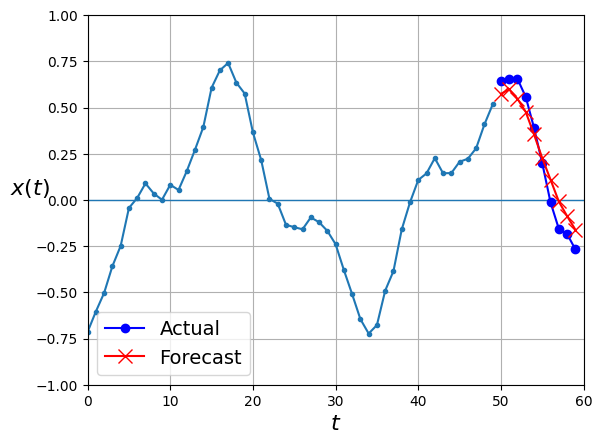

In [68]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# Using 1D Conv Layer to Process Sequence

In [69]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - last_time_step_mse: 0.0933 - loss: 0.0993 - val_last_time_step_mse: 0.0379 - val_loss: 0.0458
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - last_time_step_mse: 0.0349 - loss: 0.0416 - val_last_time_step_mse: 0.0267 - val_loss: 0.0352
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - last_time_step_mse: 0.0272 - loss: 0.0345 - val_last_time_step_mse: 0.0222 - val_loss: 0.0315
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - last_time_step_mse: 0.0225 - loss: 0.0309 - val_last_time_step_mse: 0.0195 - val_loss: 0.0290
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - last_time_step_mse: 0.0189 - loss: 0.0282 - val_last_time_step_mse: 0.0164 - val_loss: 0.0266
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - last_time_step_mse: 0.0156 - loss: 0.0259 - val_last_time_step_mse: 0.0140 - val_loss: 0.0249
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - last_time_step_mse: 0.0137 - loss: 0.0245 - val_las

# Wavenet

In [70]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - last_time_step_mse: 0.0924 - loss: 0.1004 - val_last_time_step_mse: 0.0212 - val_loss: 0.0353
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - last_time_step_mse: 0.0197 - loss: 0.0328 - val_last_time_step_mse: 0.0159 - val_loss: 0.0286
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - last_time_step_mse: 0.0156 - loss: 0.0278 - val_last_time_step_mse: 0.0137 - val_loss: 0.0261
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - last_time_step_mse: 0.0139 - loss: 0.0260 - val_last_time_step_mse: 0.0127 - val_loss: 0.0249
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - last_time_step_mse: 0.0129 - loss: 0.0249 - val_last_time_step_mse: 0.0121 - val_loss: 0.0241
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - last_time_step_mse: 0.0123 - loss: 0.0241 - val_last_time_step_mse: 0.0116 - val_loss: 0.0234
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - last_time_step_mse: 0.0117 - loss: 0.0235 - val_last_time_step_mse:

In [71]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [72]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [73]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [74]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=2,
                    validation_data=(X_valid, Y_valid))

Epoch 1/2
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - last_time_step_mse: 0.1318 - loss: 0.1361 - val_last_time_step_mse: 0.1197 - val_loss: 0.1227
Epoch 2/2
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - last_time_step_mse: 0.1176 - loss: 0.1223 - val_last_time_step_mse: 0.1186 - val_loss: 0.1215


# Exercises
``` 
Q1. Few applications for: 
a. sequence-to-sequence - all producing output in the timeseries - Predicting Weather, language translation (Encoder - Decoder architecture), video captioning, speech to text, music generation (or other sequence generation), identifying chords of music

b. sequence-to-vector - only last one producting output in series - Genre classification, Sentiment Analysis, Book/Movies review, predciting word in a pattern, recommendation engines based on history

c. vector-to-sequence - input one time and output multiple time in series - Image captioning, creating music playlist based on embedding of artist, generating melody based on pattern


Q2. how many dimensions must input have of RNN? What are these dimensions and what about the output?
Ans: Dimensions of input should be - 
[Batch Size, timesteps, Dimensionality]
Batch Size - Number of items in a given time 
timestep - Number of timesteps 
Dimensionality - Number of items for that time step say wind speed and temperature
Say if we have 5 timeseries each with 10 time step and we want to process 2 values per time step we would give
(5, 10, 2)
Outputs are also 3 Dimensional with first 2 same as batch size and timestep. However, 3rd dimension is number of neurons. If there are 32 neurons in the layer it would output [5,10,32]

Q3. If building deep RNN which RNN layer should have return_sequence=True? What about sequence-to-vectors? 
Ans: For seq-to-seq -> return_sequence=True to be set for all layers
For vec-to-seq -> return_sequence=True to be set for all layers except first one

Q4. If you have daily univariate timeseries, and you want to forecast the next 7 days? Which RNN architecture to use? 
Ans: Simplest one would be use RNN layers with all return_sequence=True except top layer. Use 7 neurons in the last layer. This will be sequence-to-vector setup 
You can also set return_sequence for all layers making it seq-to-seq architecture

Q5. Main difficulties when training RNN? And how to handle them?
Ans: Unstable Gradient and Short term memory for longer sequence

Unstable Gradient - can be handled with BN layer between layers or having Layer normalization 
Short term memory problem - LTSM and GRU Cells 

Q6. Sketch LTSM architecure - in copy 
Q7. Why to use Conv1D layer in RNN ?
Ans: Shorten the input sequence. 

Q8. Which neural network architecture for video classification 
Ans: First run all frames - 1 frame per second to Conv1D -> Feed this as input to sequence-to-vector 



# Q9. Training SketchRNN 


In [1]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

NameError: name 'keras' is not defined

In [ ]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])